In [1]:
#Selection of stars: APOGEE DR17

In [2]:
#The following cuts were motivated by Hegedus et al. 2022 (https://arxiv.org/ads/2211.03416)

In [3]:
#import mandatory libraries

In [4]:
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
import pandas as pd
import numpy as np
import os 

%matplotlib inline

In [5]:
#in/out folders 

In [6]:
output_folder = '/arc/projects/k-pop/catalogues/calsurvey/'
input_folder = '/arc/projects/k-pop/catalogues/'

In [8]:
os.chdir(input_folder)

In [9]:
#read APOGEE DR17

In [17]:
%%time
apogeedr17 = Table.read('sdss-apogee-dr17.fits')

CPU times: user 6.12 s, sys: 2.1 s, total: 8.21 s
Wall time: 11.4 s


In [18]:
#definition of cuts and flags
#bitmasks reference: https://www.sdss4.org/dr17/irspec/apogee-bitmasks/#APOGEEBitmasks

In [19]:
f_star_bad = np.bitwise_and(apogeedr17['ASPCAPFLAG'] , 2**23) == 0 #filter bad stars
f_m_h_bad = np.bitwise_and(apogeedr17['ASPCAPFLAG'] , 2**3) == 0 #filter bad [M/H] stars
f_alpha_m_bad = np.bitwise_and(apogeedr17['ASPCAPFLAG'] , 2**4) == 0 #filter bad [alpha/M] stars

In [20]:
f_snr = apogeedr17['SNR'] >= 100. #per resolution element #filter stars by signal-to-noise
f_vscatter = apogeedr17['VSCATTER'] <= 1. #km/s #filter stars by velocity scatter (repeated observations)
f_verr = apogeedr17['VERR'] <= 1. #km/s #filter stars by velocity errors (bad measurements)

In [21]:
#merge all cuts to create the best table
f_total_apogee = f_star_bad & f_m_h_bad & f_alpha_m_bad & f_snr & f_vscatter & f_verr

In [22]:
#apply the cuts and filters while removing Vesta (calibration)
apogeedr17 = apogeedr17[f_total_apogee]
apogeedr17 = apogeedr17[1:] #remove 1st line of calibration (Vesta)

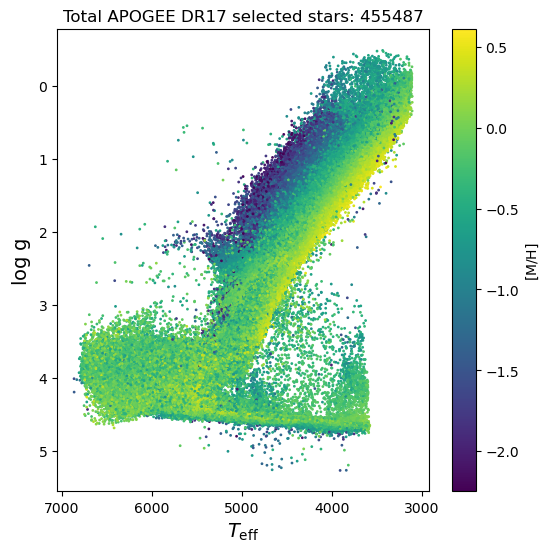

In [23]:
plt.figure(figsize=(6,6))

plt.scatter(apogeedr17['TEFF'], apogeedr17['LOGG'], c=apogeedr17['M_H'], s=1, rasterized=True)
plt.colorbar(label=r'${\rm [M/H]}$')

plt.title('Total APOGEE DR17 selected stars: %i' %np.sum(f_total_apogee))
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.xlabel(r'$T_{\rm eff}$', size=14)
plt.ylabel(r'${\rm log\ g}$', size=14)

plt.show()

In [24]:
#Add survey_name column to the final table
apogeedr17['origin'] = ['origin'] * apogeedr17['RA'].size

In [26]:
#declare and filter what columns are mandatory
required_columns = ['GAIAEDR3_SOURCE_ID', 'origin', 'APOGEE_ID', 'RA', 'DEC', 'VHELIO_AVG', 'VERR', 'TEFF', 'TEFF_ERR', 
                    'LOGG', 'LOGG_ERR', 'FE_H', 'FE_H_ERR', 'ALPHA_M', 'ALPHA_M_ERR']

In [27]:
apogeedr17 = apogeedr17[required_columns]

In [28]:
#Change columns names 
final_columns_names = ['dr3_source_id', 'origin', 'origin_id', 'ra', 'dec', 'rv', 'e_rv', 'teff', 'e_teff', 
                    'logg', 'e_logg', 'feh', 'e_feh', 'alpha_fe', 'e_alpha_fe']

In [29]:
apogeedr17.rename_columns(required_columns, final_columns_names)

In [30]:
#go back to the output folder
os.chdir(output_folder)

In [31]:
#change to pandas because I got an error
apogee_to_write = apogeedr17.to_pandas()

In [32]:
apogee_to_write.dropna(inplace=True)

In [33]:
# apogeedr17.write('apogee_filtered.parquet', format='parquet', overwrite=True)
apogee_to_write.to_parquet('apogee_dr17_filtered.parquet', index=False)
apogee_to_write.to_csv('apogee_dr17_filtered.csv', index=False, header=True)

In [34]:
!ls -lhtr 

total 143M
-rw-r--r--. 1 sfabbro sfabbro  140 Dec  6 14:19 columns.txt
-rw-rwxr--+ 1 sfabbro sfabbro  31M Dec  6 14:43 galah_dr3_filtered.parquet
-rw-r--r--. 1 sfabbro sfabbro 774K Dec  6 14:48 galah.ipynb
-rw-r--r--. 1 fgran   fgran    38M Dec  6 15:21 apogee_dr17_filtered.parquet
-rw-r--r--. 1 fgran   fgran    75M Dec  6 15:21 apogee_dr17_filtered.csv
